_Lambda School Data Science — Classification 2_ 



# Class Imbalance, ROC AUC

### Objectives 
- Understand why accuracy is a misleading metric when classes are imbalanced
- Use classification metric: ROC AUC
- Visualize the ROC curve by plotting true positive rate vs false positive rate at varying thresholds
- Use the class_weight parameter in scikit-learn

### Libraries

#### category_encoders
- Local Anaconda: `conda install -c conda-forge category_encoders`
- Google Colab: `pip install category_encoders`

#### [mlxtend](http://rasbt.github.io/mlxtend/) (to plot decision regions)
- Local Anaconda: `conda install -c conda-forge mlxtend`
- Google Colab: Already installed

#### [tqdm](https://tqdm.github.io/) (for progress bars)
- Local Anaconda: `conda install -c conda-forge tqdm`
- Google Colab: Already installed

## Lending Club Review 🏦

This sprint, your project is with Lending Club data, historical and current. Predict if peer-to-peer loans are charged off or fully paid. Decide which loans to invest in.

#### Background

[According to Wikipedia,](https://en.wikipedia.org/wiki/Lending_Club)

> Lending Club is the world's largest peer-to-peer lending platform. Lending Club enables borrowers to create unsecured personal loans between \\$1,000 and \\$40,000. The standard loan period is three years. **Investors can search and browse the loan listings on Lending Club website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose.** Investors make money from interest. Lending Club makes money by charging borrowers an origination fee and investors a service fee.

Lending Club's article about [Benefits of diversification](https://www.lendingclub.com/investing/investor-education/benefits-of-diversification) explains,

> **With the investment minimum of \\$1,000, you can get up to 40 Notes at \\$25 each.**

You can read more good context in [Data-Driven Investment Strategies for Peer-to-Peer Lending: A Case Study for Teaching Data Science](https://www.liebertpub.com/doi/full/10.1089/big.2018.0092):

> Current refers to a loan that is still being reimbursed in a timely manner. Late corresponds to a loan on which a payment is between 16 and 120 days overdue. If the payment is delayed by more than 121 days, the loan is considered to be in Default. If LendingClub has decided that the loan will not be paid off, then it is given the status of Charged-Off.

> These dynamics imply that 5 months after the term of each loan has ended, every loan ends in one of two LendingClub states—fully paid or charged-off. We call these two statuses fully paid and defaulted, respectively, and we refer to a loan that has reached one of these statuses as expired. **One way to simplify the problem is to consider only loans that have expired at the time of analysis.**

> A significant portion (13.5%) of loans ended in Default status; depending on how much of the loan was paid back, these loans
might have resulted in a significant loss to investors who had invested in them. The remainder was Fully Paid—the borrower fully reimbursed the loan’s outstanding balance with interest, and the investor earned a positive return on his or her investment. Therefore, to avoid unsuccessful investments, **our goal is to estimate which loans are more likely to default and which will yield low returns.**

In [1]:
#conda install -c conda-forge category_encoders

In [2]:
#conda install -c conda-forge mlxtend

In [3]:
#conda install -c conda-forge tqdm

In [4]:
history_location = '../data/lending-club-subset.csv'
current_location = '../data/primaryMarketNotes_browseNotes_1-RETAIL.csv'

# # For Google Colab, uncomment:
history_location = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Classification-2/master/data/lending-club-subset.csv'
current_location = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Classification-2/master/data/primaryMarketNotes_browseNotes_1-RETAIL.csv'

In [5]:
import pandas as pd
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

# Stratified sample, 10% of expired Lending Club loans, grades A-D
# Source: https://www.lendingclub.com/info/download-data.action
history = pd.read_csv(history_location)
history['issue_d'] = pd.to_datetime(history['issue_d'], infer_datetime_format=True)

# Current loans available for manual investing, June 17, 2019
# Source: https://www.lendingclub.com/browse/browse.action
current = pd.read_csv(current_location)

In [6]:
# Calculate percent of each loan repaid
history['percent_paid'] = history['total_pymnt'] / history['funded_amnt']

# See percent paid for charged off vs fully paid loans
history.groupby('loan_status')['percent_paid'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,22477.0,0.546541,0.278077,0.0,0.327761,0.514006,0.742090,1.490546
Fully Paid,105857.0,1.146904,0.089759,1.0,1.083836,1.132098,1.195798,1.623628


### Begin with baselines: expected value of random decisions

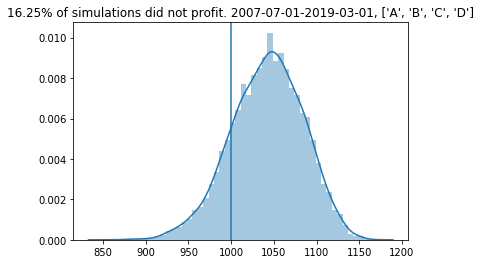

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
import seaborn as sns
from tqdm import tnrange

def simulate(n=10000, grades=['A','B','C','D'], 
             start_date='2007-07-01', 
             end_date='2019-03-01'):
    """
    What if you picked 40 random loans for $25 investments?
    How much would you have been paid back?
    
    Repeat the simulation many times, and plot the distribution 
    of probable outcomes.
    
    This doesn't consider fees or "time value of money."
    """
    
    condition = ((history['grade'].isin(grades)) & 
                 (history['issue_d'] >= start_date) &
                 (history['issue_d'] <= end_date))
    possible = history[condition]
    
    simulations = []
    for _ in tnrange(n):
        picks = possible.sample(40).copy()
        picks['paid'] = 25 * picks['percent_paid']
        paid = picks['paid'].sum()
        simulations.append(paid)
        
    simulations = pd.Series(simulations)
    sns.distplot(simulations)
    plt.axvline(x=1000)
    percent = percentileofscore(simulations, 1000)
    plt.title(f'{percent}% of simulations did not profit. {start_date}-{end_date}, {grades}')

simulate()

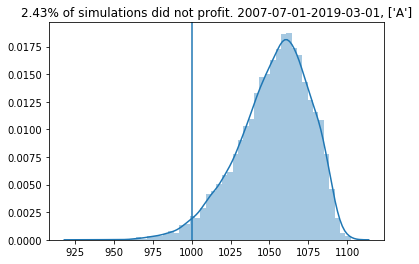

In [8]:
simulate(grades=['A'])

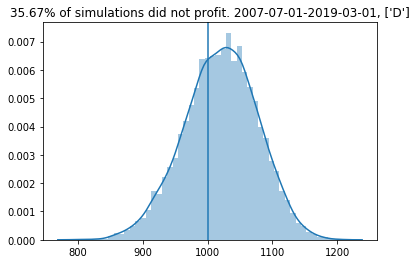

In [9]:
simulate(grades=['D'])

### Remove features to avoid leakage

In [10]:
# Transform earliest_cr_line to an integer:
# How many days the earliest credit line was open, before the loan was issued.
# For current loans available for manual investing, assume the loan will be issued today.

history['earliest_cr_line'] = pd.to_datetime(history['earliest_cr_line'], infer_datetime_format=True)
history['earliest_cr_line'] = history['issue_d'] - history['earliest_cr_line']
history['earliest_cr_line'] = history['earliest_cr_line'].dt.days

current['earliest_cr_line'] = pd.to_datetime(current['earliest_cr_line'], infer_datetime_format=True)
current['earliest_cr_line'] = pd.Timestamp.today() - current['earliest_cr_line']
current['earliest_cr_line'] = current['earliest_cr_line'].dt.days


history['issue_d_year'] = history['issue_d'].dt.year
history['issue_d_month'] = history['issue_d'].dt.month

current['issue_d_year'] = pd.Timestamp.today().year
current['issue_d_month'] = pd.Timestamp.today().month


In [11]:
# Use Python sets to compare the historical columns & current columns

common_columns = set(history.columns) & set(current.columns)
just_history = set(history.columns) - set(current.columns)
just_current = set(current.columns) - set(history.columns)

In [12]:
# Train on the historical data.
# For features, use only the common columns shared by the historical & current data.
# For the target, use `loan_status` ('Fully Paid' or 'Charged Off')

features = list(common_columns)
target = 'loan_status'
X = history[features]
y = history[target]

In [13]:
# Do train/validate/test 3-way split

from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=20000, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=20000, 
    stratify=y_trainval, random_state=42)

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (88334, 108)
y_train shape (88334,)
X_val shape (20000, 108)
y_val shape (20000,)
X_test shape (20000, 108)
y_test shape (20000,)


## Understand why accuracy is a misleading metric when classes are imbalanced

### Get accuracy score for majority class baseline

In [14]:
y_train.value_counts(normalize = True)

Fully Paid     0.824858
Charged Off    0.175142
Name: loan_status, dtype: float64

In [15]:
import numpy as np
from sklearn.metrics import accuracy_score
majority_class = 'Fully Paid'
majority_class = y_train.mode()[0]
y_pred = np.full_like(y_val, fill_value = majority_class)
accuracy_score(y_val, y_pred)

0.82485

### Get confusion matrix for majority class baseline

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

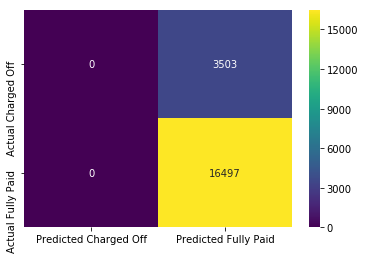

In [17]:
plot_confusion_matrix(y_val, y_pred);

### Get precision & recall for majority class baseline

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

/Users/danielcalimayor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

 Charged Off       0.00      0.00      0.00      3503
  Fully Paid       0.82      1.00      0.90     16497

   micro avg       0.82      0.82      0.82     20000
   macro avg       0.41      0.50      0.45     20000
weighted avg       0.68      0.82      0.75     20000



/Users/danielcalimayor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/danielcalimayor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Get ROC AUC score for majority class baseline
[sklearn.metrics.roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

In [19]:
from sklearn.metrics import roc_auc_score

# wat ifwe predicted 100% probability of the positive class for every prediction?
#this is like the majority class baseline, but with predicted probabilities,
#instead of just discrete classes.
#VERY IMPORTANT - Use predicted probabilities with ROC AUC score!
#Because, it is a metric of how well you rank/sort predicted probabilities!

y_pred_proba = np.full_like(y_val, fill_value = 1.00)
roc_auc_score(y_val, y_pred_proba)

0.5

In [20]:
# ROC AUC is 0.50 by definition when predicting any constant probablility value
y_pred_proba = np.full_like(y_val , fill_value = 0)
roc_auc_score(y_val, y_pred_proba)

0.5

In [21]:
y_pred_proba = np.full_like(y_val , fill_value = 0.50)
roc_auc_score(y_val, y_pred_proba)

0.5

### Fit a model

#### Count missing values

In [22]:
null_counts = X_train.isnull().sum().sort_values(ascending=False)
null_counts.reset_index()

,index,0
0,member_id,88334
1,sec_app_mths_since_last_major_derog,87855
2,sec_app_revol_util,86968
3,sec_app_mort_acc,86954
4,sec_app_inq_last_6mths,86954
5,sec_app_collections_12_mths_ex_med,86954
6,sec_app_chargeoff_within_12_mths,86954
7,sec_app_open_act_il,86954
8,sec_app_open_acc,86954
9,sec_app_fico_range_low,86954


In [23]:
many_nulls = null_counts[:73].index
print(list(many_nulls))

['member_id', 'sec_app_mths_since_last_major_derog', 'sec_app_revol_util', 'sec_app_mort_acc', 'sec_app_inq_last_6mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_chargeoff_within_12_mths', 'sec_app_open_act_il', 'sec_app_open_acc', 'sec_app_fico_range_low', 'revol_bal_joint', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_num_rev_accts', 'annual_inc_joint', 'dti_joint', 'desc', 'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_last_major_derog', 'mths_since_recent_revol_delinq', 'il_util', 'mths_since_rcnt_il', 'total_cu_tl', 'total_bal_il', 'open_rv_12m', 'open_il_24m', 'inq_last_12m', 'open_rv_24m', 'inq_fi', 'max_bal_bc', 'all_util', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'mths_since_last_delinq', 'mths_since_recent_inq', 'num_tl_120dpd_2m', 'mo_sin_old_il_acct', 'emp_title', 'emp_length', 'pct_tl_nvr_dlq', 'avg_cur_bal', 'total_rev_hi_lim', 'num_tl_op_past_12m', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'mo_sin_old_rev_tl_op', 'tot_coll_

#### Wrangle data

In [25]:

def wrangle(X):
    X = X.copy()
    
     # Engineer new feature for every feature: is the feature null?
    for col in X:
        X[col+'_NULL'] = X[col].isnull()
    

    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
        
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)
    
    
    X['title'] = X['title'].str.len()
    X['desc'] = X['desc'].str.len()
    X['emp_title'] = X['emp_title'].str.len()
    
    sub_grade_ranks = {'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5, 'B1': 6, 'B2': 7, 
                       'B3': 8, 'B4': 9, 'B5': 10, 'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 
                       'C5': 15, 'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20}
    X['sub_grade'] = X['sub_grade'].map(sub_grade_ranks)
    
    
    

    many_nulls = ['member_id', 'sec_app_mths_since_last_major_derog', 'sec_app_revol_util', 
                  'sec_app_open_act_il', 'sec_app_chargeoff_within_12_mths', 'sec_app_mort_acc', 
                  'sec_app_fico_range_high', 'revol_bal_joint', 'sec_app_collections_12_mths_ex_med', 
                  'sec_app_inq_last_6mths', 'sec_app_num_rev_accts', 'sec_app_open_acc', 
                  'sec_app_earliest_cr_line', 'sec_app_fico_range_low', 'annual_inc_joint', 
                  'dti_joint', 'desc', 'mths_since_last_record', 'mths_since_recent_bc_dlq', 
                  'mths_since_last_major_derog', 'mths_since_recent_revol_delinq', 'il_util', 
                  'mths_since_rcnt_il', 'all_util', 'open_il_12m', 'total_bal_il', 'open_il_24m', 
                  'inq_last_12m', 'open_rv_12m', 'max_bal_bc', 'open_act_il', 'open_rv_24m', 'inq_fi', 
                  'open_acc_6m', 'total_cu_tl', 'mths_since_last_delinq', 'mths_since_recent_inq', 
                  'num_tl_120dpd_2m', 'mo_sin_old_il_acct', 'emp_title', 'emp_length', 'pct_tl_nvr_dlq', 
                  'avg_cur_bal', 'mo_sin_rcnt_rev_tl_op', 'num_actv_bc_tl', 'num_il_tl', 
                  'mo_sin_rcnt_tl', 'total_rev_hi_lim', 'tot_cur_bal', 'num_bc_tl', 'num_tl_30dpd', 
                  'num_op_rev_tl', 'mo_sin_old_rev_tl_op', 'total_il_high_credit_limit', 
                  'num_rev_tl_bal_gt_0', 'num_accts_ever_120_pd', 'num_tl_90g_dpd_24m', 
                  'num_tl_op_past_12m', 'num_rev_accts', 'tot_hi_cred_lim', 'tot_coll_amt', 
                  'num_actv_rev_tl', 'bc_util', 'percent_bc_gt_75', 'bc_open_to_buy', 
                  'mths_since_recent_bc', 'num_bc_sats', 'num_sats', 'total_bc_limit', 
                  'acc_open_past_24mths', 'total_bal_ex_mort', 'mort_acc', 'title']
    
    for col in many_nulls:
        X[col] = X[col].isnull()
    

    for col in X:
        if X[col].isnull().sum() > 0:
            X[col] = X[col].fillna(X[col].mean())
            
    # Drop some columns
    X = X.drop(columns='id')
    X = X.drop(columns='member_id')
    X = X.drop(columns='title')
    X = X.drop(columns='grade')
    X = X.drop(columns='zip_code')

    
    return X


X_train = wrangle(X_train)
X_val   = wrangle(X_val)
X_test  = wrangle(X_test)

In [26]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('ordinalencoder', OrdinalEncoder(cols=['addr_state', 'application_type', 'initial_list_status', 'home_ownership', 'term', 'url', 'purpose'],
        drop_invariant=False, handle_unknown='impute', impute_missing=True,
        mapping=[{'col': 'addr_state', 'mapping': [('MO', 1), ('NC', 2), ('...imators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

### Get accuracy score for model

In [28]:
y_pred = pipeline.predict(X_val)
accuracy_score(y_val, y_pred)

0.82455

### Get confusion matrix for model

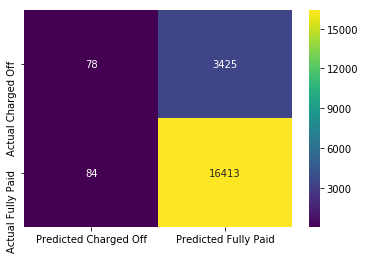

In [29]:
plot_confusion_matrix(y_val, y_pred);

### Get precision & recall for model

In [30]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

 Charged Off       0.48      0.02      0.04      3503
  Fully Paid       0.83      0.99      0.90     16497

   micro avg       0.82      0.82      0.82     20000
   macro avg       0.65      0.51      0.47     20000
weighted avg       0.77      0.82      0.75     20000



### Get ROC AUC score for model


##Got my Accuracy score a little higher than the lecture's AUC's Score

In [31]:
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_proba)

0.6856615475428529

## Understand ROC AUC (Receiver Operating Characteristic, Area Under the Curve)

#### Scikit-Learn docs
- [User Guide: Receiver operating characteristic (ROC)](https://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc)
- [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
- [sklearn.metrics.roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

#### More links
- [ROC curves and Area Under the Curve explained](https://www.dataschool.io/roc-curves-and-auc-explained/)
- [The philosophical argument for using ROC curves](https://lukeoakdenrayner.wordpress.com/2018/01/07/the-philosophical-argument-for-using-roc-curves/)

[Wikipedia explains,](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) "A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings."

ROC AUC is the area under the ROC curve. [It can be interpreted](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it) as "the expectation that a uniformly drawn random positive is ranked before a uniformly drawn random negative." 

ROC AUC measures how well a classifier ranks predicted probabilities. It ranges from 0 to 1. A naive majority class baseline will have an ROC AUC score of 0.5. 

## Visualize the ROC curve by plotting true positive rate vs false positive rate at varying thresholds

In [32]:
from ipywidgets import interact, fixed
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils.multiclass import unique_labels

def set_threshold(y_true, y_pred_proba, threshold=0.5):
    """
    For binary classification problems. 
    y_pred_proba : predicted probability of class 1
    """
    
    class_0, class_1 = unique_labels(y_true)
    y_pred = np.full_like(y_true, fill_value=class_0)
    y_pred[y_pred_proba > threshold] = class_1
    

    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='red')
    plt.title('Distribution of predicted probabilities')
    plt.show()

    true_positives = (y_pred==y_true) & (y_pred==class_1)
    false_positives = (y_pred!=y_true) & (y_pred==class_1)
    actual_positives = (y_true==class_1)
    actual_negatives = (y_true==class_0)
    true_positive_rate = true_positives.sum() / actual_positives.sum()
    false_positive_rate = false_positives.sum() / actual_negatives.sum()
    print('False Positive Rate', false_positive_rate)
    print('True Positive Rate', true_positive_rate)
    
    fpr, tpr, thresholds = roc_curve(y_true==class_1, y_pred_proba)
    plt.plot(fpr, tpr)
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.scatter(false_positive_rate, true_positive_rate)
    plt.show()
    
    print('Area under the Receiver Operating Characteristic curve:', 
          roc_auc_score(y_true, y_pred_proba))
    
    plot_confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred))

interact(set_threshold, 
         y_true=fixed(y_val), 
         y_pred_proba=fixed(y_pred_proba), 
         threshold=(0,1,0.05));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

### Use the class_weight parameter in scikit-learn

Here's a fun demo you can explore! The next code cells do five things:

#### 1. Generate data

We use scikit-learn's [make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function to generate fake data for a binary classification problem, based on several parameters, including:
- Number of samples
- Weights, meaning "the proportions of samples assigned to each class."
- Class separation: "Larger values spread out the clusters/classes and make the classification task easier."

(We are generating fake data so it is easy to visualize.)

#### 2. Split data

We split the data three ways, into train, validation, and test sets. (For this toy example, it's not really necessary to do a three-way split. A two-way split, or even no split, would be ok. But I'm trying to demonstrate good habits, even in toy examples, to avoid confusion.)

#### 3. Fit model

We use scikit-learn to fit a [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) on the training data.

We use this model parameter:

> **class_weight : _dict or ‘balanced’, default: None_**

> Weights associated with classes in the form `{class_label: weight}`. If not given, all classes are supposed to have weight one.

> The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples / (n_classes * np.bincount(y))`.


#### 4. Evaluate model

We use our Logistic Regression model, which was fit on the training data, to generate predictions for the validation data.

Then we print [scikit-learn's Classification Report](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report), with many metrics, and also the accuracy score. We are comparing the correct labels to the Logistic Regression's predicted labels, for the validation set. 

#### 5. Visualize decision function

Based on these examples
- https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/combine/plot_comparison_combine.html
- http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/#example-1-decision-regions-in-2d

In [33]:
from sklearn.model_selection import train_test_split

def train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, 
    random_state=None, shuffle=True):
        
    assert train_size + val_size + test_size == 1
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(train_size+val_size), 
        random_state=random_state, shuffle=shuffle)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        96
           1       1.00      0.50      0.67         4

   micro avg       0.98      0.98      0.98       100
   macro avg       0.99      0.75      0.83       100
weighted avg       0.98      0.98      0.98       100



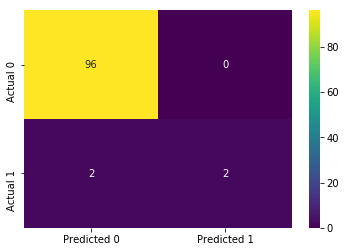

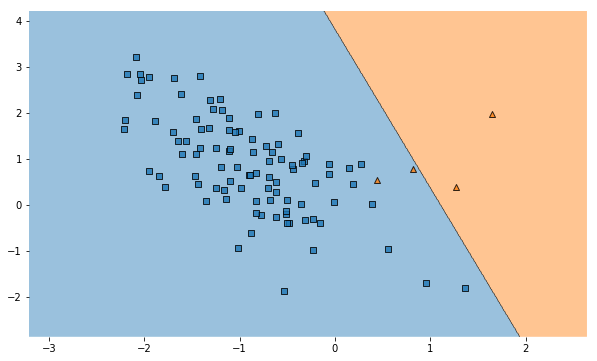

In [34]:
%matplotlib inline
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions


n_samples = 1000
weights = (0.95, 0.05)
class_sep = 0.8

X, y = make_classification(n_samples=n_samples, n_features=2, n_informative=2, 
                           n_redundant=0, n_repeated=0, n_classes=2, 
                           n_clusters_per_class=1, weights=weights, 
                           class_sep=class_sep, random_state=0)


X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=1)


class_weight = None

model = LogisticRegression(solver='lbfgs', class_weight=class_weight)
model.fit(X_train, y_train)



y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
plot_confusion_matrix(y_val, y_pred)


plt.figure(figsize=(10, 6))
plot_decision_regions(X_val, y_val, model, legend=0);

Try re-running the cell above with different values for these four parameters:
- `n_samples`
- `weights`
- `class_sep`
- `class_balance`

For example, with a 50% / 50% class distribution:
```
n_samples = 1000
weights = (0.50, 0.50)
class_sep = 0.8
class_balance = None
```

With a 95% / 5% class distribution:
```
n_samples = 1000
weights = (0.95, 0.05)
class_sep = 0.8
class_balance = None
```

With the same 95% / 5% class distribution, but changing the Logistic Regression's `class_balance` parameter to `'balanced'` (instead of its default `None`)
```
n_samples = 1000
weights = (0.95, 0.05)
class_sep = 0.8
class_balance = 'balanced'
```

With the same 95% / 5% class distribution, but with different values for `class_balance`:
- `{0: 1, 1: 1}` _(equivalent to `None`)_
- `{0: 1, 1: 2}`
- `{0: 1, 1: 10}` _(roughly equivalent to `'balanced'` for this dataset)_
- `{0: 1, 1: 100}`
- `{0: 1, 1: 10000}`

How do the evaluation metrics and decision region plots change?

## What you can do about imbalanced classes

[Learning from Imbalanced Classes](https://www.svds.com/tbt-learning-imbalanced-classes/) gives "a rough outline of useful approaches" : 

- Do nothing. Sometimes you get lucky and nothing needs to be done. You can train on the so-called natural (or stratified) distribution and sometimes it works without need for modification.
- Balance the training set in some way:
  - Oversample the minority class.
  - Undersample the majority class.
  - Synthesize new minority classes.
- Throw away minority examples and switch to an anomaly detection framework.
- At the algorithm level, or after it:
  - Adjust the class weight (misclassification costs).
  - Adjust the decision threshold.
  - Modify an existing algorithm to be more sensitive to rare classes.
- Construct an entirely new algorithm to perform well on imbalanced data.

#### We demonstrated two of these options: 

- "Adjust the class weight (misclassification costs)" — many scikit-learn classifiers have a `class_balance` parameter
- "Adjust the decision threshold" — you can lean more about this in a great blog post, [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415).

#### Another option to be aware of:
- The [imbalance-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) library can be used to "oversample the minority class, undersample the majority class, or synthesize new minority classes."

# ASSIGNMENT

- Wrangle and model the Lending Club data. Improve your ROC AUC score! Discuss on Slack.
- Explore the class_weight demo.
- Read the pre-reads (if you haven't already)
  - [ROC curves and Area Under the Curve explained](https://www.dataschool.io/roc-curves-and-auc-explained/)
  - [Learning from Imbalanced Classes](https://www.svds.com/tbt-learning-imbalanced-classes/)

### Stretch Goals

Explore these links!

- [imbalance-learn](https://github.com/scikit-learn-contrib/imbalanced-learn)
- [Machine Learning Meets Economics](http://blog.mldb.ai/blog/posts/2016/01/ml-meets-economics/)
- [The philosophical argument for using ROC curves](https://lukeoakdenrayner.wordpress.com/2018/01/07/the-philosophical-argument-for-using-roc-curves/)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)